# Base Substitution matrix

### The Pysamstats command used:
```
pysamstats --type=variation_strand --fields="chrom,pos,ref,deletions,deletions_fwd,deletions_rev,insertions,insertions_fwd,insertions_rev,A,A_fwd,A_rev,C,C_fwd,C_rev,T,T_fwd,T_rev,G,G_fwd,G_rev" --fasta=/reference.fa ./08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000.bam > ./08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000_pysamstats.csv
```

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
import time
import pickle
import os.path as osp
import tqdm
import pysam
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
BASES = ["A", "C", "G", "T"]
FILE = "./08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000_pysamstats.csv"

time_s = time.time()

num_valids = 0
num_invalids = 0 
cm_overall = np.zeros((len(BASES), len(BASES)))
perc_overall_sum = np.zeros((len(BASES), len(BASES)))
perc_overall_count = np.zeros((len(BASES), len(BASES)))

for i, chunk in enumerate(pd.read_csv(FILE, sep="\t", chunksize=10000)):
    bases_chunk = chunk[BASES]
    valids = bases_chunk.to_numpy().sum(axis=1)>=20  # max
    if sum(valids)==0:
        continue
    ref_chunk = chunk["ref"].to_numpy()[valids]
    read_chunk = chunk[BASES][valids]
    
    pred_chunk = read_chunk.idxmax(axis=1).to_numpy()
    cm_chunk = confusion_matrix(ref_chunk, pred_chunk, labels = BASES)
    cm_overall += cm_chunk

    perc_df = chunk[['ref', *BASES]][valids]
    perc_df_count = perc_df.groupby('ref').count()
    perc_df_sum = perc_df.groupby('ref').sum()
    for i, b in enumerate(BASES):
        try:
            perc_overall_sum[i,:]+=perc_df_sum.loc[b].to_numpy()
            perc_overall_count[i,:]+=perc_df_count.loc[b].to_numpy()
        except:
            pass
    
    num_valids += valids.sum()
    num_invalids += len(chunk)-valids.sum()
    
time_e = time.time()
print(time_e-time_s)

data_to_save = {"cm": cm_overall, "perc_count": perc_overall_count, 
                "perc_sum": perc_overall_sum,"num_valids": num_valids, "num_invalids": num_invalids}

with open(f"{osp.splitext(FILE)[0]}_cm.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

2.1394202709198


In [6]:
perc_overall_count = data_to_save['perc_count']
perc_overall_sum = data_to_save['perc_sum']

df = pd.DataFrame(perc_overall_sum/perc_overall_sum.sum(axis=1))
df.columns = BASES
df.index = BASES
df

,A,C,G,T
A,0.994947,0.000706,0.002322,0.001541
C,0.000783,0.996206,0.000399,0.002411
G,0.002443,0.000470,0.996279,0.000762
T,0.001830,0.002543,0.000853,0.995475


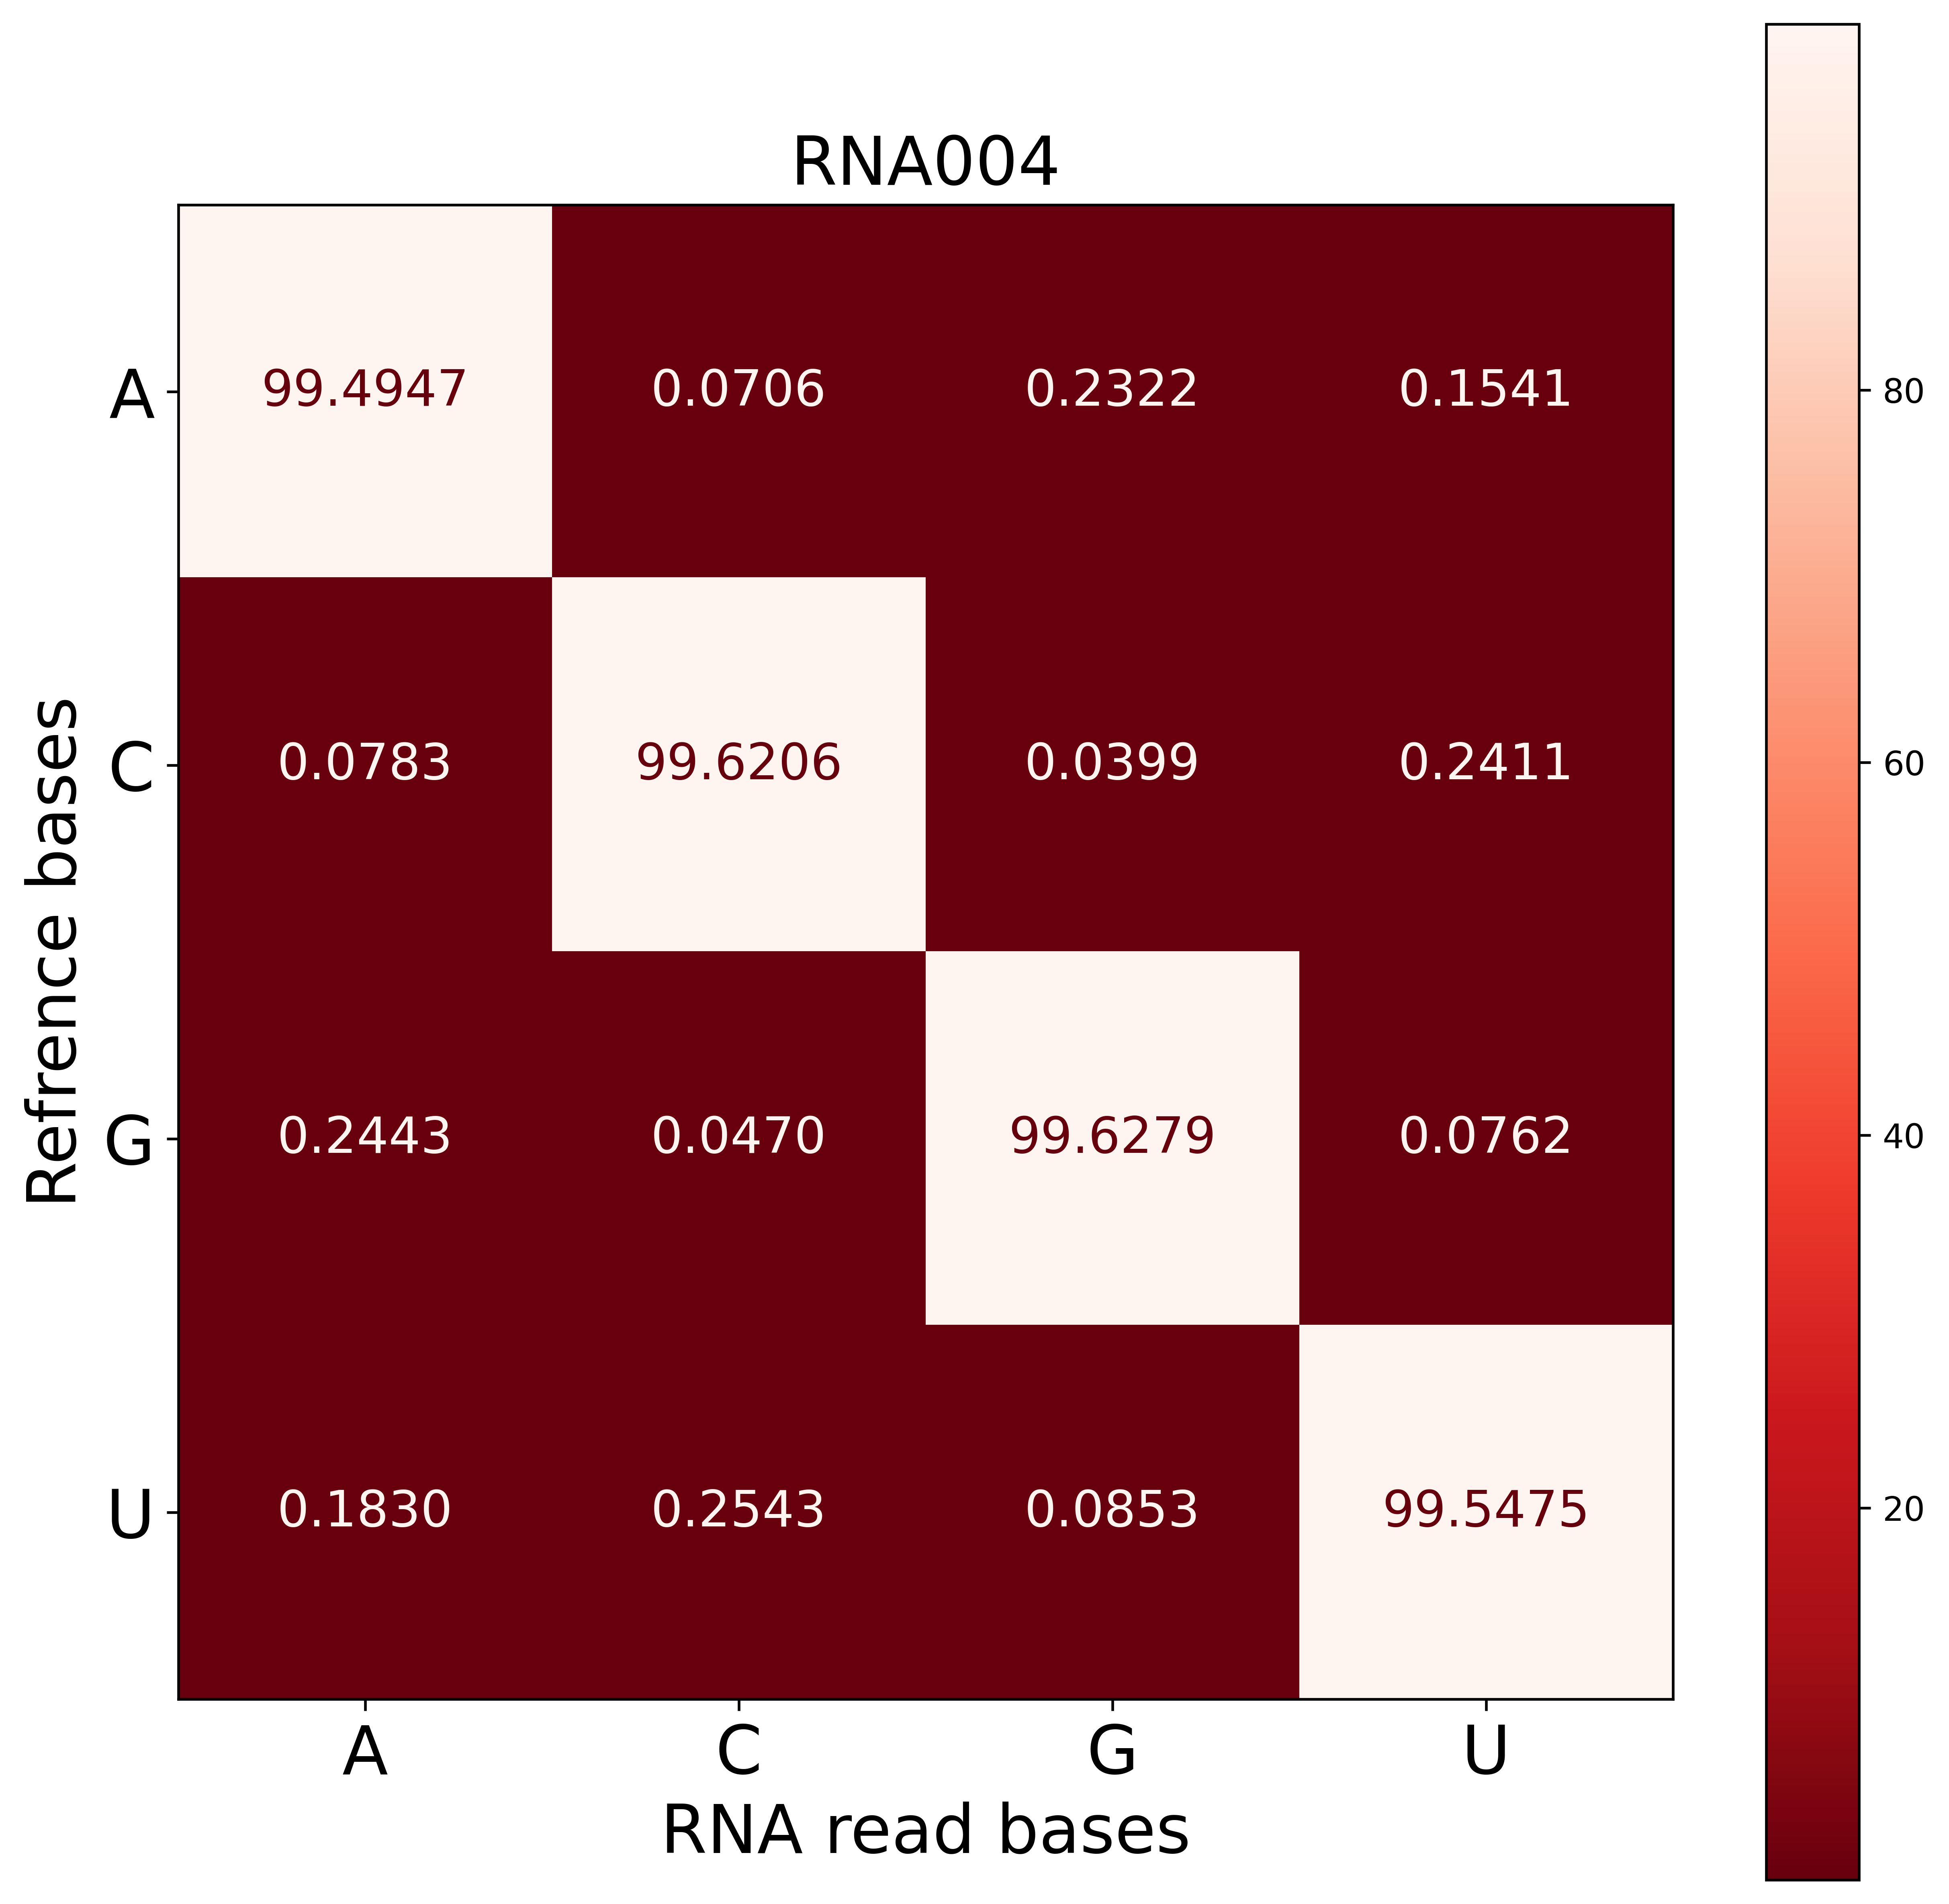

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
fig.set_dpi(600)
cm_plot = ConfusionMatrixDisplay(perc_overall_sum*100/perc_overall_sum.sum(axis=1), display_labels=['A','C','G','U'])
cm_plot.plot(cmap='Reds_r', ax=ax, values_format=".4f")
for text in ax.texts:
    text.set_fontsize(15) 

ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_title("RNA004", fontsize=20)
ax.set_ylabel("Refrence bases", fontsize=20)
ax.set_xlabel("RNA read bases", fontsize=20)
mpl.rcParams.update({'font.size': 44})
plt.show()